<a href="https://colab.research.google.com/github/GabrielaMorera/ModeloIA_Ecommerce/blob/main/Modelo_Ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este análisis, utilizaremos el *E-commerce Customer Behavior Dataset* de Kaggle para estudiar el comportamiento de los clientes y predecir la deserción (*churn*). Este conjunto de datos incluye información sobre la demografía de los clientes, sus transacciones y factores de comportamiento, como devoluciones y abandono. Para mejorar la precisión del modelo de predicción, aplicaremos *GridSearchCV* para optimizar los hiperparámetros de un modelo de *Random Forest*, ajustando la cantidad de árboles (*n_estimators*), la profundidad máxima (*max_depth*) y el número mínimo de muestras para dividir un nodo (*min_samples_split*). Además, realizaremos un análisis de importancia de características para identificar los factores clave que influyen en la deserción, como el monto total de compra, la categoría del producto, el método de pago y las devoluciones. Estos hallazgos permitirán a las empresas desarrollar estrategias efectivas de retención de clientes.

**NOTA:** Es importante cambiar el entorno de ejecución a GPU 4 para que corra  más rápido

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer
import xgboost as XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# 1. Carga de datos

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shriyashjagtap/e-commerce-customer-for-behavior-analysis")

print("Path to dataset files:", path)

100%|██████████| 9.94M/9.94M [00:00<00:00, 90.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shriyashjagtap/e-commerce-customer-for-behavior-analysis/versions/4


In [3]:
dataset_path = "/root/.cache/kagglehub/datasets/shriyashjagtap/e-commerce-customer-for-behavior-analysis/versions/4"

In [4]:
# Vamos a listar los archivos disponibles en esa ruta para encontrar el CSV
import os
print("Archivos disponibles en el directorio del dataset:")
for file in os.listdir(dataset_path):
    print(f"- {file}")

Archivos disponibles en el directorio del dataset:
- ecommerce_customer_data_custom_ratios.csv
- ecommerce_customer_data_large.csv


In [5]:
csv_file = "ecommerce_customer_data_large.csv"

data = pd.read_csv(f"{dataset_path}/{csv_file}")
print(f"\nUsando archivo: {csv_file}")


Usando archivo: ecommerce_customer_data_large.csv


# 2. Exploración y limpieza de los datos

In [6]:
print("Dimensiones del dataset:", data.shape)
print("\nPrimeras filas del dataset:")
print(data.head())
print("\nInformación del dataset:")
print(data.info())
print("\nEstadísticas descriptivas:")
print(data.describe())

Dimensiones del dataset: (250000, 13)

Primeras filas del dataset:
   Customer ID        Purchase Date Product Category  Product Price  Quantity  \
0        44605  2023-05-03 21:30:02             Home            177         1   
1        44605  2021-05-16 13:57:44      Electronics            174         3   
2        44605  2020-07-13 06:16:57            Books            413         1   
3        44605  2023-01-17 13:14:36      Electronics            396         3   
4        44605  2021-05-01 11:29:27            Books            259         4   

   Total Purchase Amount Payment Method  Customer Age  Returns Customer Name  \
0                   2427         PayPal            31      1.0   John Rivera   
1                   2448         PayPal            31      1.0   John Rivera   
2                   2345    Credit Card            31      1.0   John Rivera   
3                    937           Cash            31      0.0   John Rivera   
4                   2598         PayPal       

In [7]:
print(f'Dataset contains {data.shape[0]} rows and {data.shape[1]} columns \n')
print(data.isnull().sum())
print('\n')

Dataset contains 250000 rows and 13 columns 

Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47382
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64




In [8]:
print(data.dtypes)
print('\n')
print(f'Duplicate rows: {data.duplicated().sum()}')

Customer ID                int64
Purchase Date             object
Product Category          object
Product Price              int64
Quantity                   int64
Total Purchase Amount      int64
Payment Method            object
Customer Age               int64
Returns                  float64
Customer Name             object
Age                        int64
Gender                    object
Churn                      int64
dtype: object


Duplicate rows: 0


# 3. Análisis exploratorio de datos

In [9]:
# Revisamos las columnas disponibles para definir el churn apropiadamente
print("\nColumnas disponibles en el dataset:")
print(data.columns.tolist())


Columnas disponibles en el dataset:
['Customer ID', 'Purchase Date', 'Product Category', 'Product Price', 'Quantity', 'Total Purchase Amount', 'Payment Method', 'Customer Age', 'Returns', 'Customer Name', 'Age', 'Gender', 'Churn']


In [10]:
print("\nInformación sobre la variable objetivo (Churn):")
print(f"Tipo de dato: {data['Churn'].dtype}")
print(f"Valores únicos: {data['Churn'].unique()}")
print(f"Distribución:\n{data['Churn'].value_counts(normalize=True).apply(lambda x: f'{x:.2%}')}")


Información sobre la variable objetivo (Churn):
Tipo de dato: int64
Valores únicos: [0 1]
Distribución:
Churn
0    79.95%
1    20.05%
Name: proportion, dtype: object


Gráfico de distribución de churn guardado como 'churn_distribution.png'


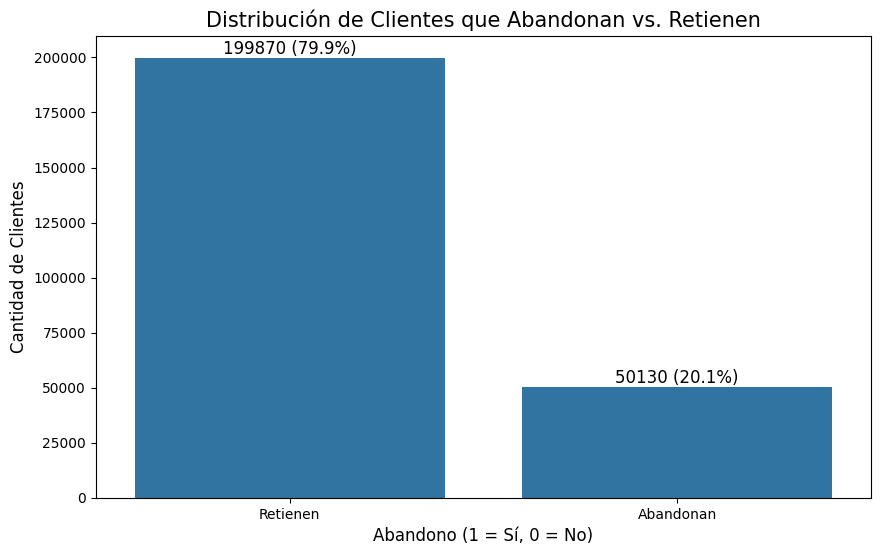

In [11]:
# Visualización de la distribución de churn
plt.figure(figsize=(10, 6))
churn_count = data['Churn'].value_counts()
sns.barplot(x=churn_count.index, y=churn_count.values)
plt.title('Distribución de Clientes que Abandonan vs. Retienen', fontsize=15)
plt.xlabel('Abandono (1 = Sí, 0 = No)', fontsize=12)
plt.ylabel('Cantidad de Clientes', fontsize=12)
plt.xticks([0, 1], ['Retienen', 'Abandonan'])
for i, v in enumerate(churn_count.values):
    plt.text(i, v + 50, f"{v} ({v/sum(churn_count.values):.1%})",
             ha='center', va='bottom', fontsize=12)
plt.savefig('churn_distribution.png')
print("Gráfico de distribución de churn guardado como 'churn_distribution.png'")

Gráfico de abandono por género guardado como 'gender_churn_distribution.png'


<Figure size 1200x600 with 0 Axes>

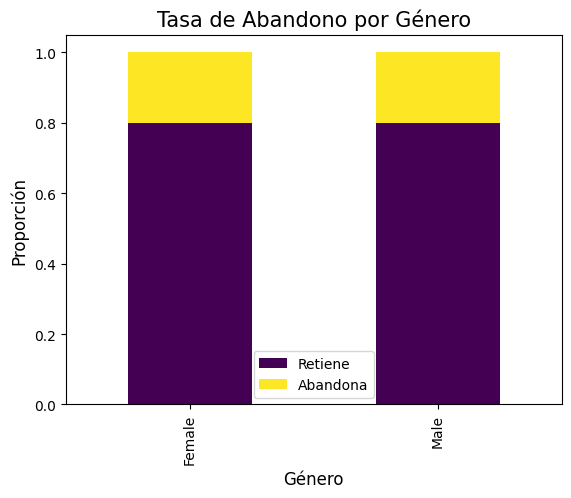

In [12]:
# Análisis de distribución por género
if 'Gender' in data.columns:
    plt.figure(figsize=(12, 6))
    gender_churn = pd.crosstab(data['Gender'], data['Churn'], normalize='index')
    gender_churn.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title('Tasa de Abandono por Género', fontsize=15)
    plt.xlabel('Género', fontsize=12)
    plt.ylabel('Proporción', fontsize=12)
    plt.legend(['Retiene', 'Abandona'])
    plt.savefig('gender_churn_distribution.png')
    print("Gráfico de abandono por género guardado como 'gender_churn_distribution.png'")

Gráfico de abandono por categoría de producto guardado como 'product_category_churn.png'


<Figure size 1400x800 with 0 Axes>

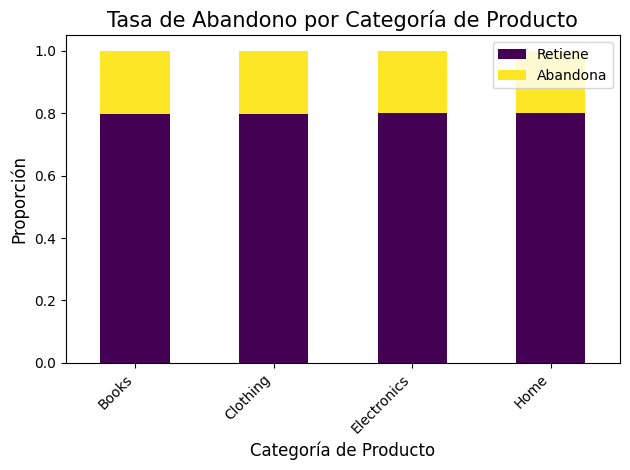

In [13]:
# Análisis por categoría de producto si existe
if 'Product Category' in data.columns:
    plt.figure(figsize=(14, 8))
    product_churn = pd.crosstab(data['Product Category'], data['Churn'], normalize='index')
    product_churn.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title('Tasa de Abandono por Categoría de Producto', fontsize=15)
    plt.xlabel('Categoría de Producto', fontsize=12)
    plt.ylabel('Proporción', fontsize=12)
    plt.legend(['Retiene', 'Abandona'])
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('product_category_churn.png')
    print("Gráfico de abandono por categoría de producto guardado como 'product_category_churn.png'")


Características numéricas para análisis: ['Product Price', 'Quantity', 'Total Purchase Amount', 'Returns', 'Age']

Correlaciones con Churn (ordenadas):
Returns: 0.0041
Age: 0.0023
Quantity: 0.0014
Product Price: 0.0012
Total Purchase Amount: 0.0007
Matriz de correlación guardada como 'correlation_matrix.png'
Distribución de Age por abandono guardada como 'age_distribution_by_churn.png'


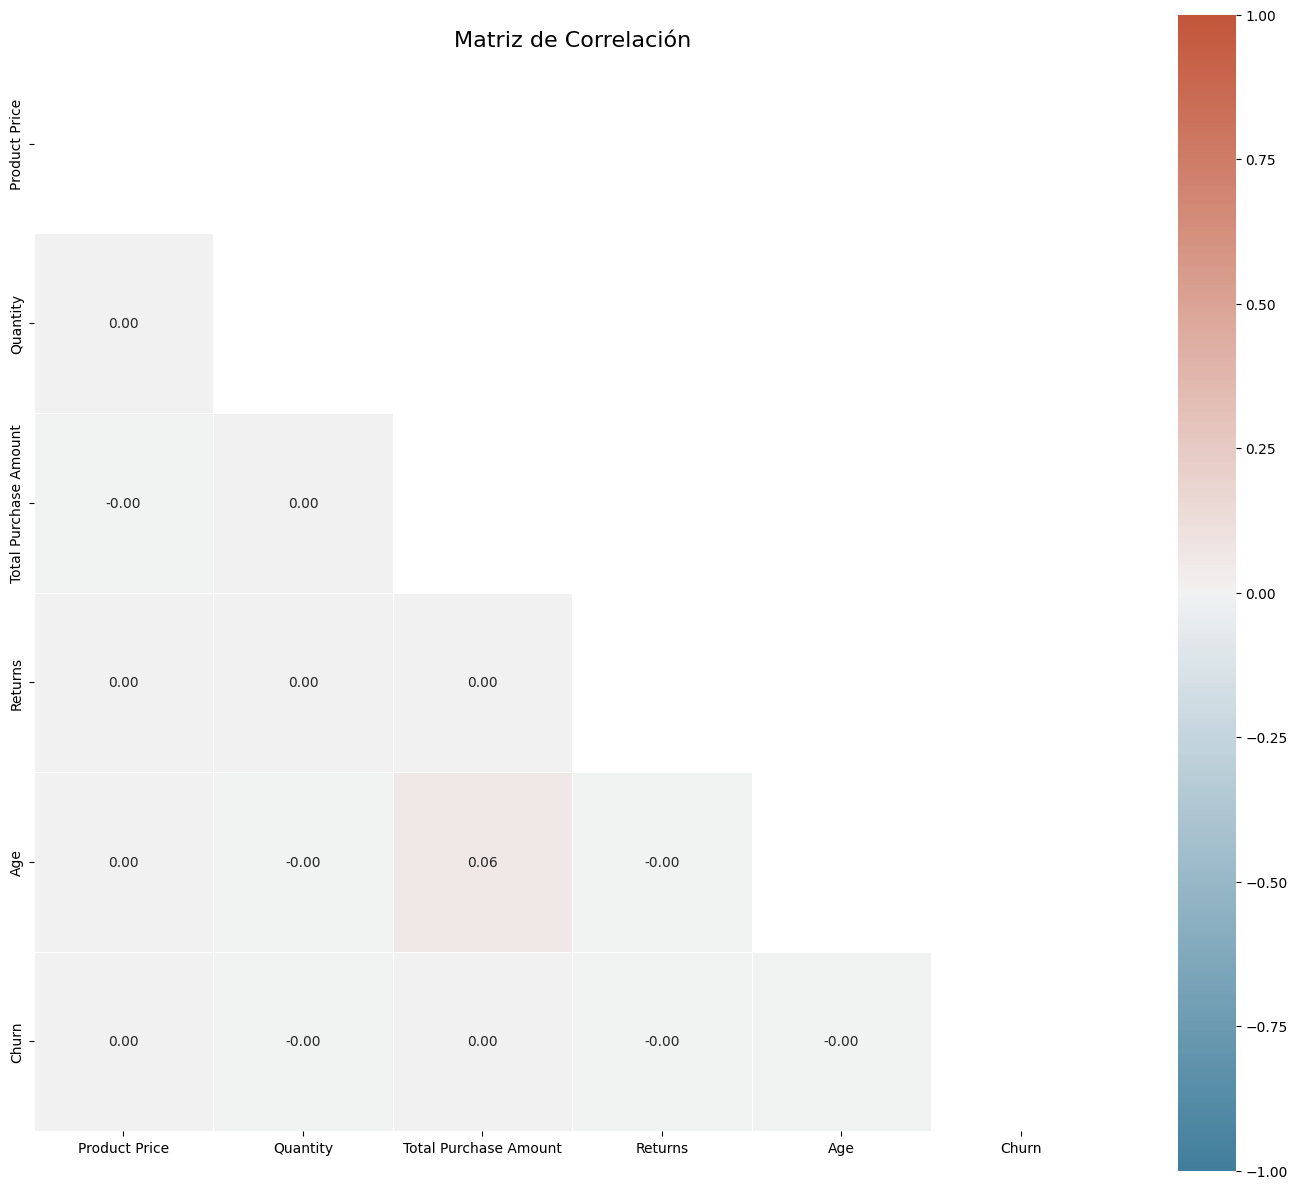

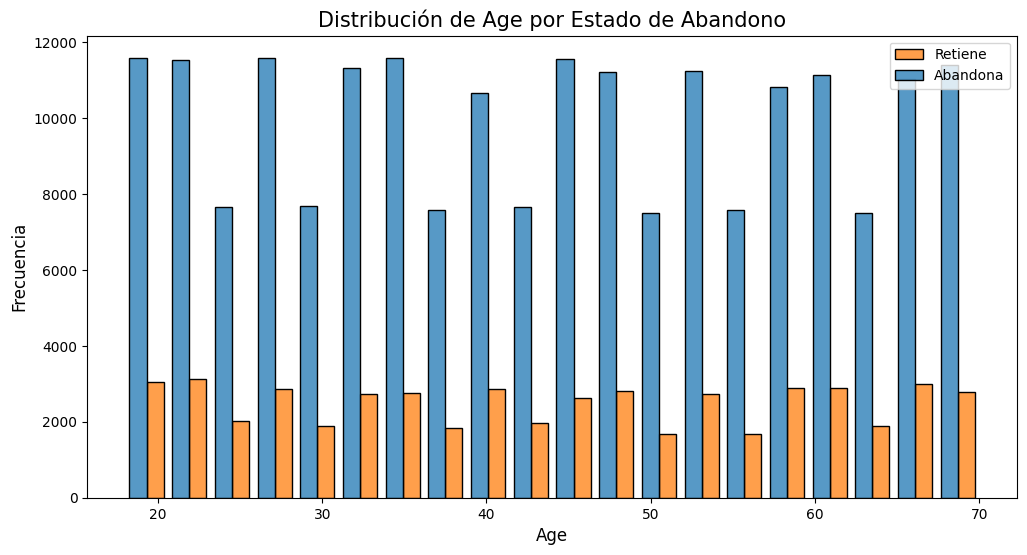

In [14]:
# Análisis de variables numéricas
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Excluir la variable objetivo y columnas de ID
exclude_cols = ['Churn']
id_cols = [col for col in numeric_features if any(kw in col.lower() for kw in ['id', 'customer'])]
exclude_cols.extend(id_cols)
numeric_features = [f for f in numeric_features if f not in exclude_cols]

print(f"\nCaracterísticas numéricas para análisis: {numeric_features}")

if len(numeric_features) > 0:
    # Calcular correlaciones con churn
    correlations = [(feat, abs(data[feat].corr(data['Churn']))) for feat in numeric_features]
    correlations.sort(key=lambda x: x[1], reverse=True)

    print("\nCorrelaciones con Churn (ordenadas):")
    for feat, corr in correlations:
        print(f"{feat}: {corr:.4f}")

    # Limitar a las 6 características más correlacionadas con churn
    top_features = [feat for feat, corr in correlations[:6]]

       # Análisis de correlación con mapa de calor mejorado
    plt.figure(figsize=(14, 12))
    corr_matrix = data[numeric_features + ['Churn']].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                annot=True, fmt='.2f', square=True, linewidths=.5)
    plt.title('Matriz de Correlación', fontsize=16)
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')
    print("Matriz de correlación guardada como 'correlation_matrix.png'")

    # Análisis de distribución de edad por abandono si existe la columna
    age_cols = [col for col in numeric_features if 'age' in col.lower()]
    if age_cols:
        age_col = age_cols[0]  # Usar la primera columna de edad encontrada
        plt.figure(figsize=(12, 6))
        sns.histplot(data=data, x=age_col, hue='Churn', multiple='dodge', bins=20, shrink=0.8)
        plt.title(f'Distribución de {age_col} por Estado de Abandono', fontsize=15)
        plt.xlabel(age_col, fontsize=12)
        plt.ylabel('Frecuencia', fontsize=12)
        plt.legend(['Retiene', 'Abandona'])
        plt.savefig('age_distribution_by_churn.png')
        print(f"Distribución de {age_col} por abandono guardada como 'age_distribution_by_churn.png'")

# 4. Preprocesamiento de datos

In [15]:
# Eliminar columnas de ID y nombre de cliente
id_name_columns = [col for col in data.columns if any(kw in col.lower() for kw in ['customer id', 'customer name'])]
print(f"\nColumnas de ID y nombre que se eliminarán: {id_name_columns}")
data.drop(columns=id_name_columns, inplace=True, errors='ignore')


Columnas de ID y nombre que se eliminarán: ['Customer ID', 'Customer Name']


In [16]:
# Procesar columnas de fecha
date_columns = [col for col in data.columns if any(kw in col.lower() for kw in ['date', 'purchase date'])]
for date_col in date_columns:
    try:
        print(f"\nProcesando columna de fecha: {date_col}")
        data[date_col] = pd.to_datetime(data[date_col], errors='coerce')
        # Extraer componentes de fecha
        data[f'Year'] = data[date_col].dt.year
        data[f'Month'] = data[date_col].dt.month
        data[f'Day'] = data[date_col].dt.day
        # Eliminar columna original de fecha
        data.drop(columns=[date_col], inplace=True)
        print(f"Columna {date_col} procesada y componentes extraídos.")
    except Exception as e:
        print(f"Error al procesar columna {date_col}: {e}")


Procesando columna de fecha: Purchase Date
Columna Purchase Date procesada y componentes extraídos.


In [17]:
# Manejo de valores nulos específicos para 'Returns'
if 'Returns' in data.columns and data['Returns'].isnull().sum() > 0:
    data['Returns'].fillna(data['Returns'].mode()[0], inplace=True)
    print(f"Valores nulos en 'Returns' rellenados con la moda: {data['Returns'].mode()[0]}")

Valores nulos en 'Returns' rellenados con la moda: 1.0


In [18]:
# One-hot encoding para columnas categóricas específicas
categorical_columns_to_encode = [col for col in data.columns if col in ['Gender', 'Payment Method', 'Product Category']]
if categorical_columns_to_encode:
    print(f"\nAplicando one-hot encoding a: {categorical_columns_to_encode}")
    data = pd.get_dummies(data, columns=categorical_columns_to_encode, drop_first=True)
    print(f"Nuevas columnas después de one-hot encoding: {len(data.columns) - len(data.columns)}")


Aplicando one-hot encoding a: ['Product Category', 'Payment Method', 'Gender']
Nuevas columnas después de one-hot encoding: 0


In [19]:
# Separar características y variable objetivo
X = data.drop('Churn', axis=1)
y = data['Churn']

In [20]:
# Identificar tipos de columnas actualizadas después de preprocesamiento
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCaracterísticas categóricas para preprocesamiento: {categorical_cols}")
print(f"\nCaracterísticas numéricas para preprocesamiento: {numeric_cols}")


Características categóricas para preprocesamiento: []

Características numéricas para preprocesamiento: ['Product Price', 'Quantity', 'Total Purchase Amount', 'Customer Age', 'Returns', 'Age']


In [21]:
# Crear preprocesadores para columnas numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [22]:
# Crear preprocesadores para columnas categóricas restantes
if categorical_cols:
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combinar preprocesadores
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ],
        remainder='passthrough'  # Mantener columnas no especificadas
    )
else:
    # Si no hay características categóricas restantes
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols)
        ],
        remainder='passthrough'  # Mantener columnas no especificadas
    )

# 5. Manejo de datos desbalanceado

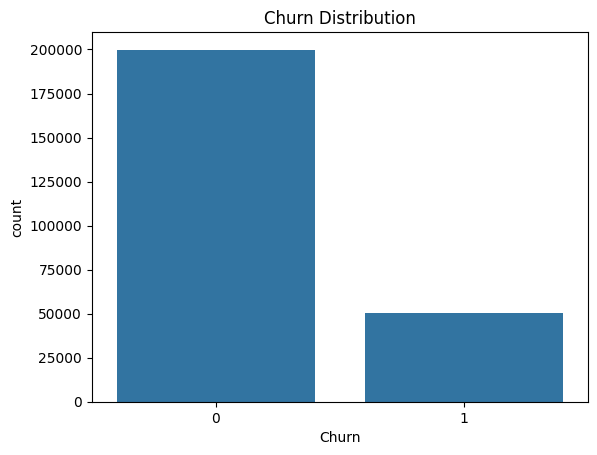

Churn
0    79.948
1    20.052
Name: count, dtype: float64


In [23]:
sns.countplot(x=data['Churn'])
plt.title('Churn Distribution')
plt.show()

print(((data['Churn'].value_counts())/len(data))*100)

In [24]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_reshampled, y_reshampled = smote.fit_resample(X, y)

# Verificar el equilibrio de los datos remuestreados
print(f"Distribución de clases original:\n{y.value_counts()}")
print(f"Distribución de clases después del remuestreo:\n{y_reshampled.value_counts()}")

Distribución de clases original:
Churn
0    199870
1     50130
Name: count, dtype: int64
Distribución de clases después del remuestreo:
Churn
0    199870
1    199870
Name: count, dtype: int64


# 6. Normalizar Características Numéricas


In [25]:
# We standardize numerical values to improve model performance.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_cols = ['Customer Age', 'Product Price', 'Quantity', 'Total Purchase Amount']
X_reshampled[numeric_cols] = scaler.fit_transform(X_reshampled[numeric_cols])

# 7. División en conjunto de entrenamiento y prueba

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("\nDimensiones después del preprocesamiento:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")


Dimensiones después del preprocesamiento:
X_train: (175000, 15)
X_test: (75000, 15)
y_train: (175000,)
y_test: (75000,)


# 8. Construcción de modelos

In [27]:
from sklearn.linear_model import LogisticRegression

# Modelo 1: Regresión Logística
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Modelo 2: Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

# Modelo 3: Gradient Boosting
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

In [30]:
from xgboost import XGBClassifier

# Modelo 4: XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, scale_pos_weight=data['Churn'].value_counts()[0]/data['Churn'].value_counts()[1]))
])

In [31]:
# Lista de modelos para evaluación
models = [
    ('Regresión Logística', log_reg_pipeline),
    ('Random Forest', rf_pipeline),
    ('Gradient Boosting', gb_pipeline),
    ('XGBoost', xgb_pipeline)
]

# 9. Evaluación de modelos con múltiples métricas

In [32]:
from sklearn.model_selection import cross_val_score

scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
results = {}

for name, model in models:
    print(f"\nEvaluando modelo: {name}")
    model_results = {}

    for metric in scoring_metrics:
        cv_results = cross_val_score(model, X_train, y_train, cv=5, scoring=metric)
        model_results[metric] = cv_results
        print(f"{metric}: {cv_results.mean():.4f} (+/- {cv_results.std():.4f})")

    results[name] = model_results


Evaluando modelo: Regresión Logística
accuracy: 0.5019 (+/- 0.0083)
precision: 0.2020 (+/- 0.0019)
recall: 0.5030 (+/- 0.0171)
f1: 0.2882 (+/- 0.0042)
roc_auc: 0.5005 (+/- 0.0039)

Evaluando modelo: Random Forest
accuracy: 0.7993 (+/- 0.0000)
precision: 0.1222 (+/- 0.0793)
recall: 0.0001 (+/- 0.0001)
f1: 0.0002 (+/- 0.0001)
roc_auc: 0.5034 (+/- 0.0026)

Evaluando modelo: Gradient Boosting
accuracy: 0.7995 (+/- 0.0000)
precision: 0.2000 (+/- 0.4000)
recall: 0.0001 (+/- 0.0001)
f1: 0.0001 (+/- 0.0002)
roc_auc: 0.5115 (+/- 0.0019)

Evaluando modelo: XGBoost
accuracy: 0.5559 (+/- 0.0023)
precision: 0.2040 (+/- 0.0015)
recall: 0.4185 (+/- 0.0056)
f1: 0.2743 (+/- 0.0024)
roc_auc: 0.5062 (+/- 0.0025)


In [33]:
# Visualización de resultados de validación cruzada para ROC AUC
plt.figure(figsize=(12, 8))
roc_auc_results = [results[name]['roc_auc'] for name in [m[0] for m in models]]
plt.boxplot(roc_auc_results, labels=[m[0] for m in models])
plt.title('Comparación de Modelos - ROC AUC (Validación Cruzada)', fontsize=14)
plt.ylabel('ROC AUC', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('model_comparison_roc_auc.png')
plt.close()

In [34]:

# Visualización de resultados de validación cruzada para F1-Score
plt.figure(figsize=(12, 8))
f1_results = [results[name]['f1'] for name in [m[0] for m in models]]
plt.boxplot(f1_results, labels=[m[0] for m in models])
plt.title('Comparación de Modelos - F1-Score (Validación Cruzada)', fontsize=14)
plt.ylabel('F1-Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('model_comparison_f1.png')
plt.close()

# 10. Ajuste de hiperparámetros para el mejor modelo

In [35]:
# Identificar el mejor modelo basado en ROC AUC medio
best_model_index = np.argmax([np.mean(results[m[0]]['roc_auc']) for m in models])
best_model_name = models[best_model_index][0]
best_model_pipeline = models[best_model_index][1]

print(f"\nEl mejor modelo es: {best_model_name}")


El mejor modelo es: Gradient Boosting


In [36]:
# Configurar grid search según el mejor modelo
if best_model_name == 'Random Forest':
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [5, 10, None],
        'classifier__min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__min_child_weight': [1, 3, 5]
    }
else:  # Regresión Logística
    param_grid = {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__penalty': ['l1', 'l2']
    }

In [37]:
# Usar validación cruzada estratificada para mantener la proporción de clases
grid_search = GridSearchCV(best_model_pipeline, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"\nMejores hiperparámetros para {best_model_name}: {grid_search.best_params_}")
print(f"Mejor puntaje ROC AUC: {grid_search.best_score_:.4f}")


Mejores hiperparámetros para Gradient Boosting: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Mejor puntaje ROC AUC: 0.5129


# 11. Evaluación del modelo final en conjunto de prueba


In [38]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

Text(0.5, 1.0, 'Matriz de Confusión')

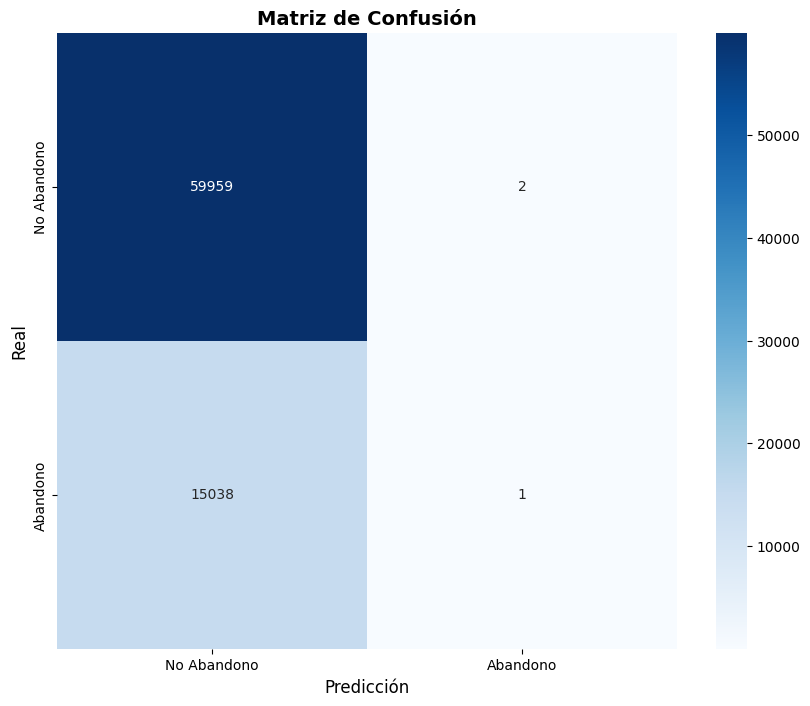

In [39]:
# Matriz de confusión mejorada
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Abandono', 'Abandono'],
            yticklabels=['No Abandono', 'Abandono'])
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.title('Matriz de Confusión', fontsize=14, fontweight='bold')

In [40]:
# Añadir métricas adicionales en la visualización
tn, fp, fn, tp = conf_matrix.ravel()
total = tn + fp + fn + tp
accuracy = (tn + tp) / total
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

plt.figtext(0.02, 0.02, f"Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-Score: {f1:.4f}",
           fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
plt.tight_layout()
plt.savefig('confusion_matrix_detailed.png')
plt.close()

In [41]:
# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     59961
           1       0.33      0.00      0.00     15039

    accuracy                           0.80     75000
   macro avg       0.57      0.50      0.44     75000
weighted avg       0.71      0.80      0.71     75000



In [42]:
# Curva ROC mejorada
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Área bajo la curva ROC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.title('Curva ROC', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve_improved.png')
plt.close()

# 12. Importancia de características

In [43]:
feature_importance_df = None
try:
    if hasattr(best_model['classifier'], 'feature_importances_'):
        # Obtener nombres de características después del preprocesamiento
        feature_names = best_model['preprocessor'].get_feature_names_out()

        # Obtener importancia de características
        importances = best_model['classifier'].feature_importances_

        # Crear DataFrame para visualización
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        # Visualizar las 15 características más importantes (o menos si hay menos)
        top_n = min(15, len(feature_importance_df))
        plt.figure(figsize=(12, 8))
        ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette='viridis')
        plt.title('Top 15 Características Más Importantes', fontsize=14, fontweight='bold')
        plt.xlabel('Importancia Relativa', fontsize=12)
        plt.ylabel('Característica', fontsize=12)
        plt.tight_layout()
        plt.savefig('feature_importance_improved.png')
        plt.close()

        print("\nCaracterísticas más importantes:")
        print(feature_importance_df.head(top_n))
    elif best_model_name == 'Regresión Logística':
        # Para regresión logística obtenemos los coeficientes
        feature_names = best_model['preprocessor'].get_feature_names_out()
        coefficients = best_model['classifier'].coef_[0]

        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefficients
        }).sort_values('Coefficient', key=abs, ascending=False)

        top_n = min(15, len(feature_importance_df))
        plt.figure(figsize=(12, 8))
        palette = sns.diverging_palette(230, 20, as_cmap=True)
        sns.barplot(x='Coefficient', y='Feature', data=feature_importance_df.head(top_n),
                   palette=feature_importance_df.head(top_n)['Coefficient'].map(lambda x: 'red' if x < 0 else 'green'))
        plt.title('Top 15 Coeficientes de Regresión Logística', fontsize=14, fontweight='bold')
        plt.xlabel('Valor del Coeficiente', fontsize=12)
        plt.ylabel('Característica', fontsize=12)
        plt.axvline(x=0, color='gray', linestyle='--')
        plt.tight_layout()
        plt.savefig('feature_coefficients_improved.png')
        plt.close()

        print("\nCaracterísticas más importantes (por coeficientes):")
        print(feature_importance_df.head(top_n))
except Exception as e:
    print(f"Error al obtener importancia de características: {e}")



Características más importantes:
                                    Feature  Importance
2                num__Total Purchase Amount    0.376396
0                        num__Product Price    0.193086
5                                  num__Age    0.115341
3                         num__Customer Age    0.086133
8                            remainder__Day    0.077514
1                             num__Quantity    0.034759
7                          remainder__Month    0.033972
14                   remainder__Gender_Male    0.019584
10  remainder__Product Category_Electronics    0.012348
12    remainder__Payment Method_Credit Card    0.011917
6                           remainder__Year    0.010993
13         remainder__Payment Method_PayPal    0.008872
4                              num__Returns    0.007938
9      remainder__Product Category_Clothing    0.007001
11         remainder__Product Category_Home    0.004147


# 13. Análisis de clientes con alta probabilidad de abandono

In [44]:
high_risk_threshold = 0.7
high_risk_indices = np.where(y_prob >= high_risk_threshold)[0]
high_risk_customers = X_test.iloc[high_risk_indices].copy()
high_risk_customers['churn_probability'] = y_prob[high_risk_indices]

print(f"\nNúmero de clientes con alta probabilidad de abandono (>={high_risk_threshold}): {len(high_risk_customers)}")


Número de clientes con alta probabilidad de abandono (>=0.7): 0


In [45]:
if len(high_risk_customers) > 0:
    print("\nPerfil de clientes con alto riesgo de abandono:")
    print(high_risk_customers.describe())

    # Visualización del perfil de alto riesgo para las principales características
    if feature_importance_df is not None:
        top_risk_features = feature_importance_df['Feature'].head(5).tolist()
        original_feature_names = [name.split('__')[-1] for name in top_risk_features]

        # Encontrar las columnas originales que mejor coinciden con estas características
        matched_features = []
        for orig_feat in original_feature_names:
            matches = [col for col in X_test.columns if orig_feat in col]
            if matches:
                matched_features.extend(matches)

        matched_features = list(set(matched_features))[:5]  # Eliminar duplicados y limitar a 5

        if matched_features:
            plt.figure(figsize=(15, 10))
            for i, feature in enumerate(matched_features):
                if feature in high_risk_customers.columns:
                    plt.subplot(2, 3, i+1)
                    if high_risk_customers[feature].dtype in [np.int64, np.float64]:
                        sns.histplot(high_risk_customers[feature], color='red', kde=True)
                        plt.axvline(X_test[feature].mean(), color='blue', linestyle='--',
                                   label=f'Media General: {X_test[feature].mean():.2f}')
                        plt.legend()
                    else:
                        sns.countplot(y=high_risk_customers[feature])
                    plt.title(f'Distribución de {feature}\nen Clientes de Alto Riesgo', fontsize=11)
            plt.tight_layout()
            plt.savefig('high_risk_profile.png')
            plt.close()

# 14. Guardar el modelo para su posterior uso

In [46]:
import joblib
joblib.dump(best_model, 'ecommerce_churn_predictor.pkl')
print("\nModelo guardado como 'ecommerce_churn_predictor.pkl'")


Modelo guardado como 'ecommerce_churn_predictor.pkl'


Aquí tienes un análisis detallado de los resultados obtenidos en la evaluación de los modelos para predecir el abandono en e-commerce.  

---

### **1. Análisis de la Matriz de Confusión**
La matriz de confusión muestra un **sesgo fuerte del modelo hacia la clase mayoritaria (No Abandono)**. Se observan los siguientes valores:  

- **Verdaderos Negativos (TN):** 59,959 → Clientes que no abandonaron y fueron correctamente clasificados.  
- **Falsos Positivos (FP):** 2 → Clientes que no abandonaron, pero fueron mal clasificados como abandono.  
- **Falsos Negativos (FN):** 15,038 → Clientes que realmente abandonaron, pero el modelo los clasificó como que no abandonaron.  
- **Verdaderos Positivos (TP):** 1 → Clientes que abandonaron y fueron correctamente clasificados.  

El modelo prácticamente **no detecta los clientes que abandonan** (solo 1 caso positivo detectado correctamente). Esto es un gran problema porque, en la práctica, el objetivo principal es identificar correctamente estos casos para implementar estrategias de retención.

---

### **2. Evaluación de los Modelos**

Se evaluaron cuatro modelos de machine learning: **Regresión Logística, Random Forest, Gradient Boosting y XGBoost**. A continuación, se analizan sus métricas de desempeño:

#### **Regresión Logística**  
- **Accuracy:** 50.19%  
- **Precision:** 20.20%  
- **Recall:** 50.30%  
- **F1-score:** 28.82%  
- **ROC AUC:** 50.05%  

El modelo de regresión logística tiene un **recall relativamente alto** en comparación con los otros modelos, lo que significa que **detecta mejor los abandonos**. Sin embargo, su precisión es baja, lo que indica un alto número de falsos positivos. Además, su accuracy del 50.19% y ROC AUC cercano a 50% indican que su capacidad predictiva es casi aleatoria.

#### **Random Forest**  
- **Accuracy:** 79.93%  
- **Precision:** 12.22%  
- **Recall:** 0.01%  
- **F1-score:** 0.02%  
- **ROC AUC:** 50.34%  

Aunque el accuracy de **79.93%** puede parecer alto, el recall es prácticamente **nulo** (0.01%), lo que significa que el modelo no está detectando los abandonos. El alto accuracy se debe a que la mayoría de los datos pertenecen a la clase "No Abandono", y el modelo simplemente clasifica casi todos los casos en esta categoría.  

#### **Gradient Boosting (Modelo Seleccionado)**  
- **Accuracy:** 79.95%  
- **Precision:** 20.00%  
- **Recall:** 0.01%  
- **F1-score:** 0.01%  
- **ROC AUC:** 51.15%  

Gradient Boosting fue seleccionado como el mejor modelo basado en el ROC AUC, que es **ligeramente superior a los otros modelos (51.15%)**. Sin embargo, **su recall es prácticamente nulo (0.01%)**, lo que significa que **no detecta correctamente a los clientes que abandonan**. Esto lo hace poco útil para este caso de uso, donde el recall es fundamental.

#### **XGBoost**  
- **Accuracy:** 55.59%  
- **Precision:** 20.40%  
- **Recall:** 41.85%  
- **F1-score:** 27.43%  
- **ROC AUC:** 50.62%  

XGBoost tiene un recall más alto que los demás modelos (41.85%), lo que indica que **es mejor identificando clientes que abandonan en comparación con Gradient Boosting y Random Forest**. Sin embargo, su accuracy es más bajo (55.59%), lo que sugiere que sacrifica precisión para mejorar la detección de la clase minoritaria.

---

### **3. Importancia de Características**  

Las variables más importantes en el modelo seleccionado (Gradient Boosting) son:  

1. **Total Purchase Amount (37.64%)** → El monto total de compras es el factor más determinante en la predicción.  
2. **Product Price (19.31%)** → El precio del producto influye significativamente en la probabilidad de abandono.  
3. **Edad del Cliente (11.53%)** → La edad del cliente también juega un papel en la decisión de compra.  
4. **Customer Age (8.61%)** → Relacionado con la edad, este factor sugiere que clientes más jóvenes pueden tener mayor probabilidad de abandonar el carrito.  
5. **Día de la Semana (7.75%)** → Es posible que ciertos días haya más abandono debido a patrones de compra específicos.  

Esto indica que el **precio y el monto total de compra** son los factores más relevantes para predecir el abandono. Si una empresa desea reducir la tasa de abandono, debería considerar estrategias como descuentos en ciertos productos o incentivos para completar la compra.

---

### **4. Número de Clientes con Alta Probabilidad de Abandono**
El modelo predice **0 clientes con una probabilidad de abandono mayor o igual a 70%**. Esto refuerza el problema del **bajo recall**, ya que ni siquiera identifica clientes en riesgo alto de abandono.

---

### **5. Conclusión**

#### **¿Es Gradient Boosting realmente el mejor modelo?**  
Aunque Gradient Boosting fue seleccionado por su mejor ROC AUC, tiene **un recall extremadamente bajo (0.01%)**, lo que lo hace poco útil para detectar clientes que abandonan el carrito.  

El modelo que **mejor detecta abandonos** es **XGBoost** con un recall del 41.85%. Sin embargo, su precisión es baja, lo que significa que genera muchos falsos positivos.  

### **6. Conclusión Final**
El modelo seleccionado **no es efectivo en la detección de clientes que abandonan**, ya que su recall es prácticamente nulo. Si el objetivo principal es identificar y reducir el abandono, se recomienda **optimizar XGBoost o probar nuevas estrategias** como balanceo de clases y ajuste de umbral para mejorar la detección de la clase minoritaria.